In [1]:
import stackstac
import pystac_client
import numpy as np
import xarray as xr
import rioxarray
import rasterio
from affine import Affine
import geopandas as gpd
import requests
from IPython.display import display
from PIL import Image
from ipywidgets import widgets
from sklearn.ensemble import RandomForestClassifier
from ipyleaflet import Map,GeoJSON, ImageOverlay
import matplotlib
from base64 import b64encode
from io import BytesIO
from skimage.morphology import binary_erosion, binary_dilation

In [2]:
roi_gdf = gpd.read_file("../res/roi.geojson")

map = Map(center=tuple(roi_gdf.geometry[0].centroid.coords)[0][::-1], zoom=9)
map.add(
    GeoJSON(data=roi_gdf.geometry[0].__geo_interface__, style={"color": "red"})
)

Map(center=[-2.474258378662231, -50.43133406603268], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [3]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=roi_gdf.geometry[0],
    collections=["sentinel-2-l2a"],
    datetime="2015-03-01/2023-06-01"
).item_collection()

len(items)


532

In [4]:
nocloud_items = [
    item for item in items
    if (
        item.properties["eo:cloud_cover"] < 5
    )
]
len(nocloud_items)

21

Let's visualize the queried products using the preview pictures that come with them

In [5]:

widgets.GridBox(
    children = [
        widgets.VBox(
            children = [
                widgets.Label(item.id),
                widgets.Image(value=requests.get(item.assets["thumbnail"].href, stream=True).content)
            ],
            layout=widgets.Layout(border='solid',)
        )
        for item in nocloud_items[::5]
    ],
    layout=widgets.Layout(
        grid_template_columns='256px ' * 4,
    )
)

GridBox(children=(VBox(children=(Label(value='S2A_22MEC_20210821_0_L2A'), Image(value=b'\xff\xd8\xff\xe0\x00\x…

In [6]:


items[0].properties['s2:water_percentage'] / (
    items[0].properties['s2:vegetation_percentage'] +
    items[0].properties['s2:not_vegetated_percentage'] +
    items[0].properties['s2:water_percentage']
)
items[0].properties


{'created': '2023-05-28T23:02:50.432Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 56.127697,
 'proj:epsg': 32722,
 'mgrs:utm_zone': 22,
 'mgrs:latitude_band': 'M',
 'mgrs:grid_square': 'EC',
 'grid:code': 'MGRS-22MEC',
 'view:sun_azimuth': 40.4517515105393,
 'view:sun_elevation': 58.223329119247396,
 's2:degraded_msi_data_percentage': 0.0177,
 's2:nodata_pixel_percentage': 0,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 0.006466,
 's2:cloud_shadow_percentage': 7.337096,
 's2:vegetation_percentage': 29.244423,
 's2:not_vegetated_percentage': 0.52886,
 's2:water_percentage': 3.283416,
 's2:unclassified_percentage': 3.472039,
 's2:medium_proba_clouds_percentage': 19.48169,
 's2:high_proba_clouds_percentage': 28.985268,
 's2:thin_cirrus_percentage': 7.660741,
 's2:snow_ice_percentage': 0,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '05.09',
 's2:product_uri': 'S2B_MSIL2A_20230528T1

In [7]:
def preview_miniature_on_map(item):
    t = item.assets["blue"].extra_fields["proj:transform"]
    da = xr.DataArray(
        data=np.array(Image.open(requests.get(item.assets["thumbnail"].href, stream=True).raw)),
        dims = ["y", "x", "band"],
    ).transpose('band', 'y', 'x').rio.write_crs(item.properties["proj:epsg"]).rio.write_transform(
        Affine(10 * 10980 / 343, *t[1:4], -10 * 10980 / 343, t[5])
    ).rio.reproject("epsg:4326")
    im = Image.fromarray(da.transpose('y', 'x', 'band').values)

    map = Map(center=tuple(roi_gdf.geometry[0].centroid.coords)[0][::-1], zoom=9)
    f = BytesIO()
    im.save(f, "png")
    data = b64encode(f.getvalue()).decode("ascii")
    imgurl = "data:image/png;base64," + data
    a,b,c,d = da.rio.bounds()
    bounds = ((d, c), (b, a))

    map.add(ImageOverlay(url = imgurl, bounds = bounds))
    map.add(
        GeoJSON(data=roi_gdf.geometry[0].__geo_interface__, style={"color": "red", "fillOpacity": 0})
    )
    display(map)

preview_miniature_on_map(nocloud_items[12])

Map(center=[-2.474258378662231, -50.43133406603268], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [8]:
da = stackstac.stack(items)

/home/pierre/repositories/pachama-demo/.venv/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [9]:
nocloud_da = da[da["eo:cloud_cover"] < 3]
nocloud_da

<xarray.DataArray 'stackstac-eeb6b2fc99cc0106052c43852bd89338' (time: 13,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(13, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-06-03...
    id                                       (time) <U24 'S2A_22MEC_20170603_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 9.8e+06 ... 9.69e+06
    s2:reflectance_conversion_factor         (time) float64 0.9729 ... 0.9761
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32722
Attributes:
    spec:        RasterSpec(epsg=32722, bounds=(499980.0, 9690220.0, 609780.0...
    crs:         epsg:32722
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 9800020.00|\n| 0.0...
    resolution:  10.0

In [10]:
#view = nocloud_da.sel(band="nir").isel(time=0).loc[::20, ::20]
#view.plot.imshow()

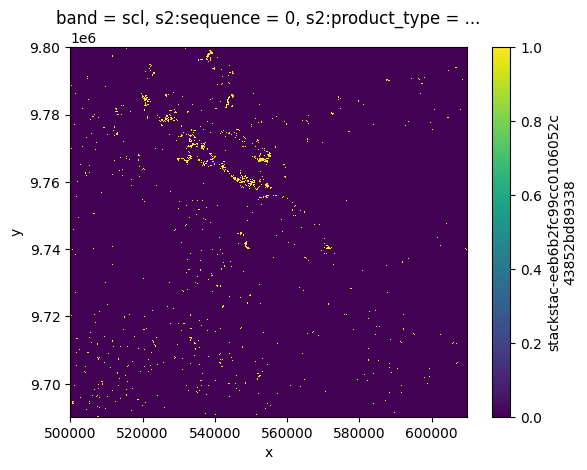

In [11]:
view = (nocloud_da.sel(band="scl").sel(time=nocloud_da.time.values[-1]).loc[::, ::] == 5) & (nocloud_da.sel(band="scl").isel(time=0).loc[::, ::] == 4)
y,x = np.ogrid[-3:7-3, -3:7-3]
mask = x*x + y*y <= 3*3
view.values = binary_dilation(view.values, footprint=mask)
for i in range(2):
    view.values = binary_erosion(view.values, footprint=mask)
for i in range(3):
    view.values = binary_dilation(view.values, footprint=mask)
view.plot.imshow()

view.rio.write_crs(view["proj:epsg"].values).astype(np.uint8).rio.to_raster("../res/test.tif")

In [12]:
rasterio

<module 'rasterio' from '/home/pierre/repositories/pachama-demo/.venv/lib/python3.10/site-packages/rasterio/__init__.py'>

In [13]:
(nocloud_da.sel(band="scl").sel(time=nocloud_da.time.values[-1]).loc[::, ::] == 6).rio.write_crs(view["proj:epsg"].values).astype(np.uint8).rio.to_raster("../res/water.tif")

In [14]:
nocloud_da.time.values[[0, -1]]

array(['2017-06-03T13:51:43.317000000', '2021-08-21T13:53:05.795000000'],
      dtype='datetime64[ns]')